https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import random
import os
from itertools import cycle
from tensorflow import keras
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Rescaling  # <-- updated import
from tensorflow.image import rgb_to_grayscale 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory as idd
import pathlib
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:

train_path = pathlib.Path('Training/')
test_path = pathlib.Path('Testing/')
# Ensure the paths are correct
if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError("Training or Testing directory does not exist.")
def load_data():
    train_ds = idd(train_path, image_size=(224, 224), batch_size=32)
    test_ds = idd(test_path, image_size=(224, 224), batch_size=32)
    return train_ds, test_ds

In [3]:
# Count the number if images in each directory
def count_images(path):
    return sum([len(files) for r, d, files in os.walk(path)])   
print(f"Number of training images: {count_images(train_path)}")
print(f"Number of testing images: {count_images(test_path)}")


Number of training images: 2871
Number of testing images: 394


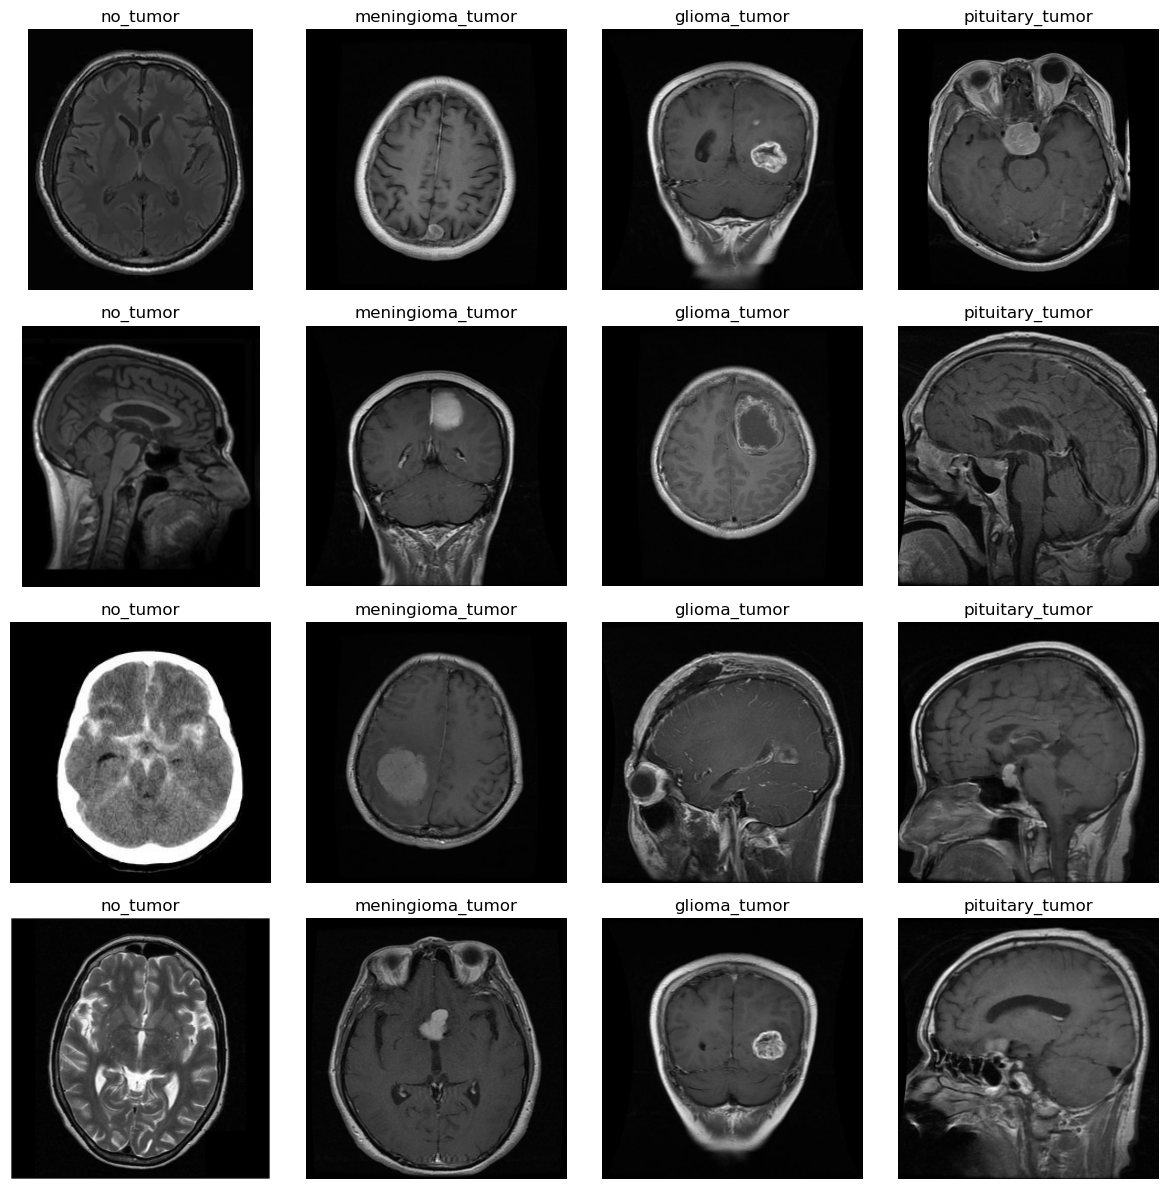

In [4]:
main_folder = r'Training'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

In [5]:
def cnn_preprocess(x):
    return x/255.0

In [6]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
    train_path,
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    
)
cnn_train_generator.class_indices

Found 2870 images belonging to 4 classes.


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [7]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
        test_path,
        color_mode='rgb',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical')

Found 394 images belonging to 4 classes.


In [14]:
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Number of output classes
num_classes = len(cnn_train_generator.class_indices)

# CNN Architecture
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),

    ModelCheckpoint(
        filepath='best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Fit the model
cnn_history = cnn_model.fit(
    cnn_train_generator,
    epochs=30,
    validation_data=cnn_test_generator,
    callbacks=callbacks
)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.5054 - auc: 0.7368 - loss: 1.9950 - precision: 0.5617 - recall: 0.3752
Epoch 1: val_accuracy improved from -inf to 0.27411, saving model to best_cnn_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 777ms/step - accuracy: 0.5063 - auc: 0.7377 - loss: 1.9884 - precision: 0.5630 - recall: 0.3758 - val_accuracy: 0.2741 - val_auc: 0.5651 - val_loss: 1.5234 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.6919 - auc: 0.9189 - loss: 0.9838 - precision: 0.7744 - recall: 0.5789
Epoch 2: val_accuracy improved from 0.27411 to 0.35787, saving model to best_cnn_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 721ms/step - accuracy: 0.6921 - auc: 0.9190 - loss: 0.9835 - precision: 0.7746 - recall: 0.5792 - val_accuracy: 0.3579 - val_auc: 0.5944 - val_loss: 1.5851 - val_precision: 0.5455 - val_recall: 0.0305 - learning_rate: 1.0000e-04
Epoch 3/30
90/9

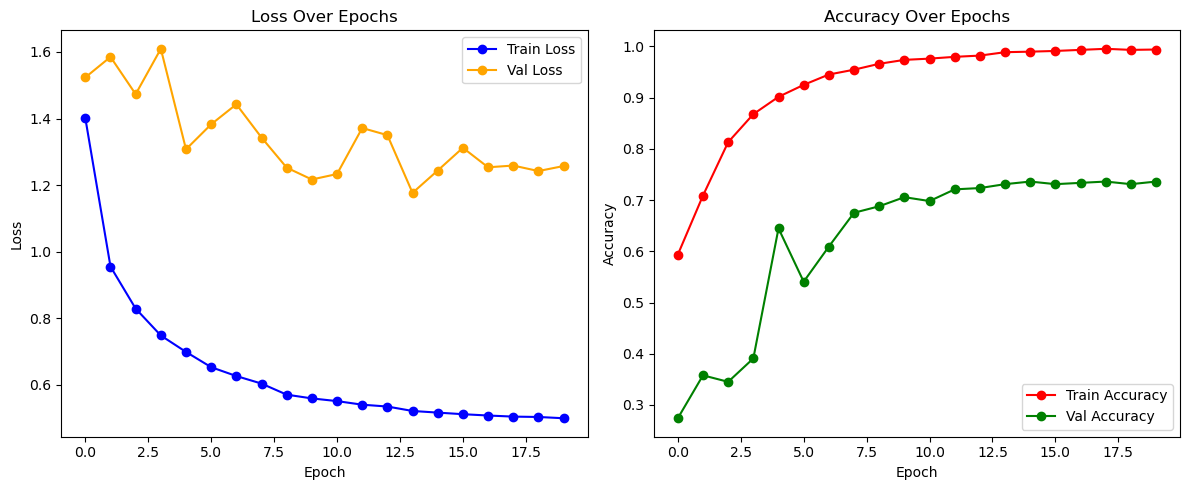

In [15]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

# 1. Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    
)

val_datagen = ImageDataGenerator(rescale=1./255)

cnn_train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

cnn_test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

num_classes = len(cnn_train_generator.class_indices)

# 2. Load pre-trained MobileNetV2 base (freeze its weights)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze the convolutional base

# 3. Build the custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# 5. Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mobilenetv2_best.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

# 6. Train the model
history = model.fit(
    cnn_train_generator,
    validation_data=cnn_test_generator,
    epochs=30,
    callbacks=callbacks
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3257 - loss: 1.7005 - precision: 0.3415 - recall: 0.2089
Epoch 1: val_accuracy improved from -inf to 0.51015, saving model to mobilenetv2_best.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.3266 - loss: 1.6975 - precision: 0.3427 - recall: 0.2093 - val_accuracy: 0.5102 - val_loss: 1.2670 - val_precision: 0.6258 - val_recall: 0.2462 - learning_rate: 1.0000e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5981 - loss: 1.0682 - precision: 0.6868 - recall: 0.4373
Epoch 2: val_accuracy improved from 0.51015 to 0.51523, saving model to mobilenetv2_best.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.5984 - loss: 1.0677 - precision: 0.6869 - recall: 0.4378 - val_accuracy: 0.5152 - val_loss: 1.3106 - val_precision: 0.6175 - val_recall: 0.3934 - learning_rate: 1.0000e-04
Epoch 3/30
90/90 ━━━━━━━━━━━

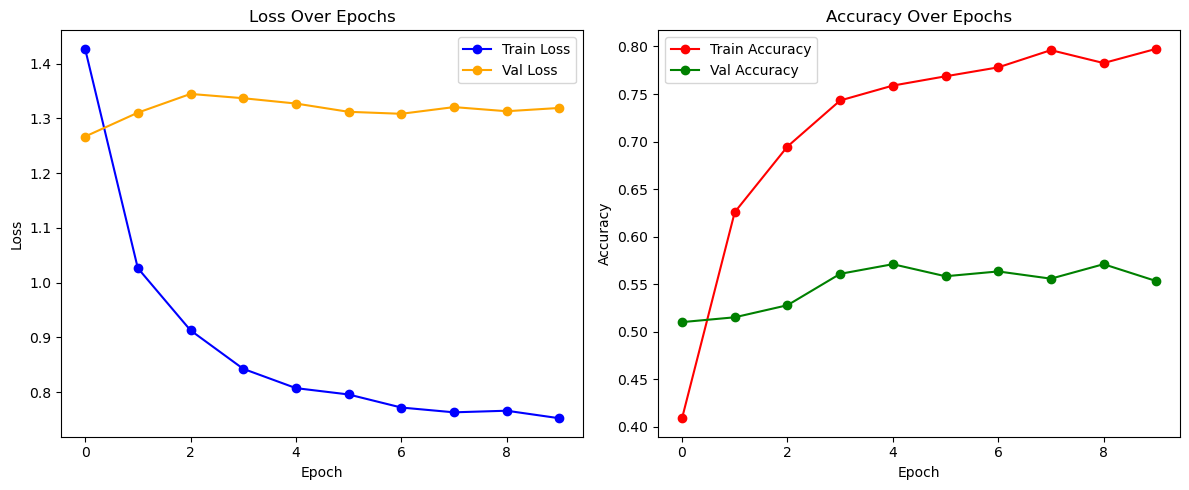

In [17]:
#Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()